In [2]:
import re
import numpy as np
np.set_printoptions(threshold=np.inf)

# function to split a line into objects by whitespaces
def ws_split(lst):
    lst = re.split(r'\s+', lst)
    lst.pop()        #remove first empty character
    lst.pop(0)       #remove last empty character
    return lst

def ws_split_int(lst):
    lst = re.split(r'\s+', lst)
    lst.pop()        #remove first empty character
    lst.pop(0)       #remove last empty character
    lst = [int(x) for x in lst]
    return lst

def instance_read(instance):
    with open(instance) as f:
        lines = f.readlines()
    d = dict();
    d['ref'] = lines[0]
    num_of_vars = d['num_of_vars'] = int(lines[1])
    d['profits'] = np.asarray(ws_split_int(lines[2]))
    combinations = [ws_split_int(i) for i in lines[3:num_of_vars+2]]
    combi_length = max(map(len, combinations))
    d['combinations'] = np.array([[0]*(combi_length-len(xi))+xi for xi in combinations])
    d['constraint_type'] = lines[int(num_of_vars)+3]
    d['capacity'] = lines[int(num_of_vars)+4]
    d['weights'] = np.asarray(ws_split_int(lines[num_of_vars+5]))
    
    return d


####
# available keys: ref (instance reference) 
# num_of_vars (n)
# profits (p_i)
# combinations (p_ij)
# constraint_type
# capacity (C_k)
# weights (w_i)
####
instance = instance_read('jeu_100_25_1.txt')
num_of_vars = instance.get("num_of_vars")
profits = instance.get("profits")
combinations = instance.get("combinations")
constraint_type = instance.get("constraint_type")
capacity = instance.get("capacity")
weights = instance.get("weights")




gen	nevals	max  	avg    
0  	50    	18281	3883.16
1  	50    	4830 	3287.02
2  	50    	4267 	3209.76
3  	50    	4186 	3167.69
4  	50    	3924 	3110.24
5  	50    	3921 	3090.01
6  	50    	3871 	3064.73
7  	50    	3758 	3040.56
8  	50    	3681 	3021.36
9  	50    	3729 	3006.45
10 	50    	3645 	2989.36
11 	50    	3645 	2988.32
12 	50    	3583 	2983.83
13 	50    	3564 	2981.31
14 	50    	3538 	2964.44
15 	50    	3504 	2946.93
16 	50    	3468 	2925.25
17 	50    	3456 	2906.52
18 	50    	3431 	2893.53
19 	50    	3381 	2885.24
20 	50    	3455 	2892.3 
21 	50    	3382 	2896.95
22 	50    	3381 	2893.93
23 	50    	3436 	2887.43
24 	50    	3408 	2883.51
25 	50    	3390 	2894.63
26 	50    	3368 	2890.36
27 	50    	3332 	2876.91
28 	50    	3332 	2867.54
29 	50    	3332 	2855.05
30 	50    	3326 	2840.38
31 	50    	3326 	2844.03
32 	50    	3326 	2847.6 
33 	50    	3326 	2839.03
34 	50    	3598 	2862.52
35 	50    	3326 	2857.36
36 	50    	3320 	2859.78
37 	50    	3314 	2850.74
38 	50    	3314 	2856.45


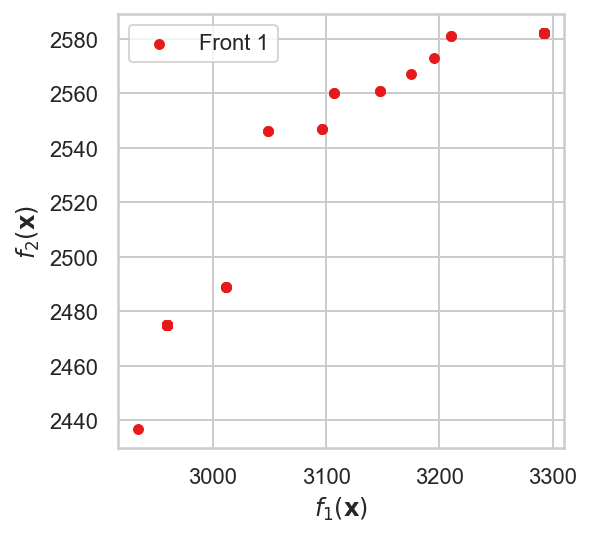

In [53]:
import time, array, random, copy, math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

from deap import algorithms, base, benchmarks, tools, creator

def feature_transform(integer_representation):
    n = len(integer_representation)
    m = max(integer_representation)
    if min(integer_representation) < 0:
        raise ValueError("One of the items is in a negative knapsack, which doesn't make sense")
    binary_matrix = np.zeros((m,n))
    for i in range(n):
        if not integer_representation[i] == 0:
            binary_matrix[integer_representation[i]-1, i] = 1
    idx = np.argwhere(np.all(binary_matrix[..., :] == 0, axis=1))
    a2 = np.delete(binary_matrix, idx, axis=0)
    return feature_revert(a2)
def feature_revert(binary_matrix):
    n = binary_matrix.shape[1]
    m = binary_matrix.shape[0]
    sol = [0] * binary_matrix.shape[1]
    result = (binary_matrix.T @ np.arange(1,m+1)).astype(int)
    return result.tolist()

#random.seed(a=42)


def eval_fitness(individual):
    global instance
    individual = feature_transform(individual)
    m = int(max(individual))
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*m
    knapsacks_profit = [0]*m
    for i in range(len(individual)):
        if individual[i] != 0:
            knapsacks_weight[individual[i]-1] += weights[i]
            knapsacks_profit[individual[i]-1] += profits[i]
            for j in range(len(individual)):
                if individual[i] == individual[j]:
                    knapsacks_profit[individual[i]-1] += combinations[i-1][j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)
    for i in range(m):
        if knapsacks_weight[i] > capacity:
            f1 += knapsacks_profit[i] * (capacity / knapsacks_weight[i])
        else:
            f1+= knapsacks_profit[i]
    f1 += m * min(knapsacks_profit)
    return f1, f2

def uniform(low, m):
    n = []
    n_kp = int(random.randint(1,m))
    for i in range(0,m):
        n.append(random.randint(0,n_kp))
    return n

creator.create("FitnessMin", base.Fitness, weights=(-1.0,1.0))
creator.create("Individual", array.array, typecode='i', 
               fitness=creator.FitnessMin)

toolbox = base.Toolbox()

BOUND_LOW, BOUND_UP = 0, instance.get("num_of_vars")
NDIM = 2
toolbox.register("evaluate", eval_fitness)

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
#toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mate", tools.cxOnePoint)
#toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.3)
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = 50
toolbox.max_gen = 50
toolbox.mut_prob = 0.2

def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=True)
    return population, logbook

%time res,_ = run_ea(toolbox)

fronts = tools.emo.sortLogNondominated(res, len(res))

plot_colors = seaborn.color_palette("Set1", n_colors=10)
fig, ax = plt.subplots(1, figsize=(4,4))
for i,inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)
    df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
                 x=df.columns[0], y=df.columns[1], 
                 color=plot_colors[i])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [70]:
import random
individual = []
m = random.randint(1,num_of_vars)            #number of knapsacks

for i in range(0,num_of_vars):
    n = random.randint(0,m)
    individual.append(n)

knapsack_capacity = capacity
def feature_transform(integer_representation):
    n = len(integer_representation)
    m = max(integer_representation)
    if min(integer_representation) < 0:
        raise ValueError("One of the items is in a negative knapsack, which doesn't make sense")
    binary_matrix = np.zeros((m,n))
    for i in range(n):
        if not integer_representation[i] == 0:
            binary_matrix[integer_representation[i]-1, i] = 1
    idx = np.argwhere(np.all(binary_matrix[..., :] == 0, axis=1))
    a2 = np.delete(binary_matrix, idx, axis=0)
    return feature_revert(a2)
def feature_revert(binary_matrix):
    n = binary_matrix.shape[1]
    m = binary_matrix.shape[0]
    sol = [0] * binary_matrix.shape[1]
    result = (binary_matrix.T @ np.arange(1,m+1)).astype(int)
    return result.tolist()
def fitness_eval(individual, instance):
    individual = feature_transform(individual)
    m = int(max(individual))
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*m
    knapsacks_profit = [0]*m
    for i in range(len(individual)):
        if individual[i] != 0:
            knapsacks_weight[individual[i]-1] += weights[i]
            knapsacks_profit[individual[i]-1] += profits[i]
            for j in range(len(individual)):
                if individual[i] == individual[j]:
                    knapsacks_profit[individual[i]-1] += combinations[i-1][j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)
    for i in range(m):
        if knapsacks_weight[i] > capacity:
            f1 += knapsacks_profit[i] * (capacity / knapsacks_weights[i])
        else:
            f1+= knapsacks_profit[i]
    f1 += m * min(knapsacks_profit)
    return f1, f2
fitness_eval(individual, instance)

### Command for adding fitness function:
## toolbox.register("evaluate", lambda x: fitness_eval(x, instance))


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(9919, 2366)

In [ ]:
import time, array, random, copy, math
import numpy as np
import pandas as pd
from random import sample

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

from deap import algorithms, base, benchmarks, tools, creator

random.seed(a=42)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

def dent(individual, lbda = 0.85):
    """ 
    Implements the test problem Dent
    Num. variables = 2; bounds in [-1.5, 1.5]; num. objetives = 2.
    @author Cesar Revelo
    """
    d  = lbda * math.exp(-(individual[0] - individual[1]) ** 2)  
    f1 = 0.5 * (math.sqrt(1 + (individual[0] + individual[1]) ** 2) + \
                math.sqrt(1 + (individual[0] - individual[1]) ** 2) + \
                individual[0] - individual[1]) + d
    f2 = 0.5 * (math.sqrt(1 + (individual[0] + individual[1]) ** 2) + \
                math.sqrt(1 + (individual[0] - individual[1]) ** 2) - \
                individual[0] + individual[1]) + d
    return f1, f2

toolbox = base.Toolbox()

BOUND_LOW, BOUND_UP = 0, 100
NDIM = 2
toolbox.register("evaluate", dent)

def uniform(low, up, size=None):
    try:
        return sample([*range(low, up+1, 1)], k=up)
    except TypeError:
        return [sample([*range(a, b+1, 1)], k=up) for a, b in zip([low] * size, [up] * size)]

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

num_samples = 50
limits = [np.arange(BOUND_LOW, BOUND_UP, (BOUND_UP - BOUND_LOW)/num_samples)] * NDIM
sample_x = np.meshgrid(*limits)

flat = []
for i in range(len(sample_x)):
    x_i = sample_x[i]
    flat.append(x_i.reshape(num_samples**NDIM))
    
example_pop = toolbox.population(n=num_samples**NDIM)

for i, ind in enumerate(example_pop):
    for j in range(len(flat)):
        ind[j] = flat[j][i]
        
fitnesses = toolbox.map(toolbox.evaluate, example_pop)
for ind, fit in zip(example_pop, fitnesses):
    ind.fitness.values = fit

def pareto_dominance(x,y):
    return tools.emo.isDominated(x.fitness.values, y.fitness.values)

dominated = [ind for ind in example_pop if pareto_dominance(a_given_individual, ind)]
dominators = [ind for ind in example_pop if pareto_dominance(ind, a_given_individual)]
others = [ind for ind in example_pop if not ind in dominated and not ind in dominators]

def plot_dent():
    'Plots the points in decision and objective spaces.'
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    for ind in dominators: plt.plot(ind[0], ind[1], 'r.')
    for ind in dominated: plt.plot(ind[0], ind[1], 'g.')
    for ind in others: plt.plot(ind[0], ind[1], 'k.', ms=3)
    plt.plot(a_given_individual[0], a_given_individual[1], 'bo', ms=6);
    plt.xlabel('$x_1$');plt.ylabel('$x_2$');
    plt.title('Decision space');
    plt.subplot(1,2,2)
    for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
    for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
    for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
    plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');
    plt.xlim((0.5,3.6));plt.ylim((0.5,3.6));
    plt.title('Objective space');
    plt.tight_layout()
    
plot_dent()

non_dom = tools.sortNondominated(example_pop, k=len(example_pop), first_front_only=True)[0]

plt.figure(figsize=(5,5))
for ind in example_pop:
    plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=3, alpha=0.5)
for ind in non_dom:
    plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'bo', alpha=0.74, ms=5)
plt.title('Pareto-optimal front')

